# Enhanced Transfer Learning CNN - EfficientNetB0

## Major Improvements:
- **Enhanced synthetic data generation** with color variations (not just black on white)
- **Targeted class balancing** for specific underrepresented classes
- **Improved architecture** with better regularization
- **Optimized hyperparameters** (LR, batch size, image size)
- **Advanced augmentation** with color jitter and more variations
- **Better focal loss** configuration for quality classes

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import cv2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2026-01-13 17:12:49.372715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768324369.572464      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768324369.627906      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768324370.068565      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768324370.068615      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768324370.068618      55 computation_placer.cc:177] computation placer alr

In [2]:
# GPU configuration
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU {gpu.name} configured")

GPU /physical_device:GPU:0 configured


## Enhanced Synthetic Data Generation with Color Variations

In [3]:
class EnhancedSketchDatasetBuilder:
    """Enhanced synthetic data generator with color variations and better quality simulation"""
    
    def __init__(self, image_size=128):  # Increased from 224 for better detail
        self.image_size = image_size
        
        self.bg_colors = [
            (255, 255, 255),  # Pure white
            (250, 250, 250),  # Very light gray
            (245, 245, 245),  # Light gray
            ]

        self.fg_colors = [
            (0, 0, 0),        # Pure black
            (15, 15, 15),     # Very dark gray
            (30, 30, 30),     # Dark gray
            ]
    
    def _get_random_colors(self):
        """Get random but visually distinct background and foreground colors"""
        bg = self.bg_colors[np.random.randint(len(self.bg_colors))]
        fg = self.fg_colors[np.random.randint(len(self.fg_colors))]
        
        # Add slight random variation
        bg = tuple(int(x) for x in np.clip(np.array(bg) + np.random.randint(-5, 6, 3), 0, 255))
        fg = tuple(int(x) for x in np.clip(np.array(fg) + np.random.randint(-10, 11, 3), 0, 255))
        
        return bg, fg
    
    def _perturb_vertices(self, vertices, quality_level):
        """Add geometric distortion based on quality level"""
        vertices = np.asarray(vertices, dtype=np.float32)
        
        if quality_level == "Perfect":
            # Minimal perturbation for perfect shapes
            max_offset = int(self.image_size * 0.01)
            distorted = vertices + np.random.uniform(-max_offset, max_offset, vertices.shape)
            return distorted.astype(np.int32)
        
        if quality_level == "Medium":
            jitter_scale = 0.05
        else:  # Irregular
            jitter_scale = 0.15
        
        max_offset = int(self.image_size * jitter_scale)
        
        distorted = []
        for x, y in vertices:
            dx = np.random.randint(-max_offset, max_offset + 1)
            dy = np.random.randint(-max_offset, max_offset + 1)
            distorted.append((x + dx, y + dy))
            
            # Add extra vertices for irregular shapes
            if quality_level == "Irregular" and np.random.rand() < 0.4:
                distorted.append((
                    x + dx + np.random.randint(-max_offset, max_offset),
                    y + dy + np.random.randint(-max_offset, max_offset)
                ))
        
        return np.array(distorted, dtype=np.int32)
    
    def _degrade_raster(self, image, quality_level):
        image = image.copy()
    
        if quality_level == "Perfect":
            # EXTREMELY minimal degradation - almost none
            # Remove blur entirely or use tiniest amount
            noise = np.random.normal(0, 0.5, image.shape)  # Change from 1
            return np.clip(image + noise, 0, 255).astype(np.uint8)
    
        if quality_level == "Medium":
            # Make Medium MORE degraded to increase separation
            image = cv2.GaussianBlur(image, (5, 5), 1.0)  # Increase from (3,3), 0.8
            noise = np.random.normal(0, 12, image.shape)   
            image = np.clip(image + noise, 0, 255).astype(np.uint8)
            
            # Random morphological operations
            kernel_size = np.random.choice([3, 5])
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            if np.random.rand() < 0.5:
                image = cv2.dilate(image, kernel, iterations=1)
            else:
                image = cv2.erode(image, kernel, iterations=1)
            
            return image
        
        # Irregular - heavy degradation
        image = cv2.GaussianBlur(image, (5, 5), 1.5)
        noise = np.random.normal(0, 20, image.shape)
        image = np.clip(image + noise, 0, 255).astype(np.uint8)
        
        # Multiple morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        for _ in range(np.random.randint(1, 4)):
            if np.random.rand() < 0.5:
                image = cv2.dilate(image, kernel, iterations=1)
            else:
                image = cv2.erode(image, kernel, iterations=1)
        
        # Add some random scratches/artifacts
        if np.random.rand() < 0.3:
            num_scratches = np.random.randint(2, 6)
            for _ in range(num_scratches):
                pt1 = (np.random.randint(0, self.image_size), np.random.randint(0, self.image_size))
                pt2 = (np.random.randint(0, self.image_size), np.random.randint(0, self.image_size))
                cv2.line(image, pt1, pt2, 
                        tuple(np.random.randint(0, 50, 3).tolist()), 
                        np.random.randint(1, 3))
        
        return image
    
    def _empty_canvas(self, bg_color):
        """Create canvas with specified background color"""
        return np.full(
            (self.image_size, self.image_size, 3),
            bg_color,
            dtype=np.uint8
        )
    
    def _draw_triangle(self, quality_level, bg_color, fg_color):
        """Draw triangle with quality variations"""
        img = self._empty_canvas(bg_color)
        c = self.image_size // 2
        scale = np.random.uniform(0.55, 0.85)
        
        # Define triangle vertices
        vertices = [
            (c, c - int(c * 0.75 * scale)),  # Top
            (c - int(c * 0.65 * scale), c + int(c * 0.65 * scale)),  # Bottom-left
            (c + int(c * 0.65 * scale), c + int(c * 0.65 * scale)),  # Bottom-right
        ]
        
        contour = self._perturb_vertices(vertices, quality_level)
        
        # Variable line thickness
        thickness = np.random.randint(2, 4) if quality_level != "Irregular" else np.random.randint(2, 5)
        cv2.drawContours(img, [contour], -1, fg_color, thickness)
        
        return self._degrade_raster(img, quality_level)
    
    def _draw_square(self, quality_level, bg_color, fg_color):
        """Draw square with quality variations"""
        img = self._empty_canvas(bg_color)
        c = self.image_size // 2
        half = int(c * np.random.uniform(0.5, 0.7))
        
        vertices = [
            (c - half, c - half),  # Top-left
            (c + half, c - half),  # Top-right
            (c + half, c + half),  # Bottom-right
            (c - half, c + half),  # Bottom-left
        ]
        
        contour = self._perturb_vertices(vertices, quality_level)
        
        thickness = np.random.randint(2, 4) if quality_level != "Irregular" else np.random.randint(2, 5)
        cv2.drawContours(img, [contour], -1, fg_color, thickness)
        
        return self._degrade_raster(img, quality_level)
    
    def _draw_circle(self, quality_level, bg_color, fg_color):
        """Draw circle with quality variations"""
        img = self._empty_canvas(bg_color)
        c = self.image_size // 2
        r = int(c * np.random.uniform(0.55, 0.75))
        
        thickness = np.random.randint(2, 4) if quality_level != "Irregular" else np.random.randint(2, 5)
        
        if quality_level == "Perfect":
            # Perfect circle
            cv2.circle(img, (c, c), r, fg_color, thickness)
        else:
            # Ellipse with varying axis ratios
            if quality_level == "Medium":
                axis_jitter = 0.15
            else:  # Irregular
                axis_jitter = 0.35
            
            rx = int(r * (1 + np.random.uniform(-axis_jitter, axis_jitter)))
            ry = int(r * (1 + np.random.uniform(-axis_jitter, axis_jitter)))
            angle = np.random.uniform(0, 360)
            
            cv2.ellipse(img, (c, c), (abs(rx), abs(ry)), angle, 0, 360, fg_color, thickness)
        
        return self._degrade_raster(img, quality_level)
    
    def render_sample(self, shape_name, quality_level):
        """Generate a synthetic sample with color variations"""
        bg_color, fg_color = self._get_random_colors()
        
        dispatch = {
            "Triangle": self._draw_triangle,
            "Square": self._draw_square,
            "Circle": self._draw_circle,
        }
        
        return dispatch[shape_name](quality_level, bg_color, fg_color)
    
    def visualize_samples(self, num_samples=9):
        """Visualize generated samples"""
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        shapes = ["Circle", "Square", "Triangle"]
        qualities = ["Perfect", "Medium", "Irregular"]
        
        for i, shape in enumerate(shapes):
            for j, quality in enumerate(qualities):
                img = self.render_sample(shape, quality)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{shape} - {quality}", fontweight='bold')
                axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.show()

Visualizing enhanced synthetic data generation...


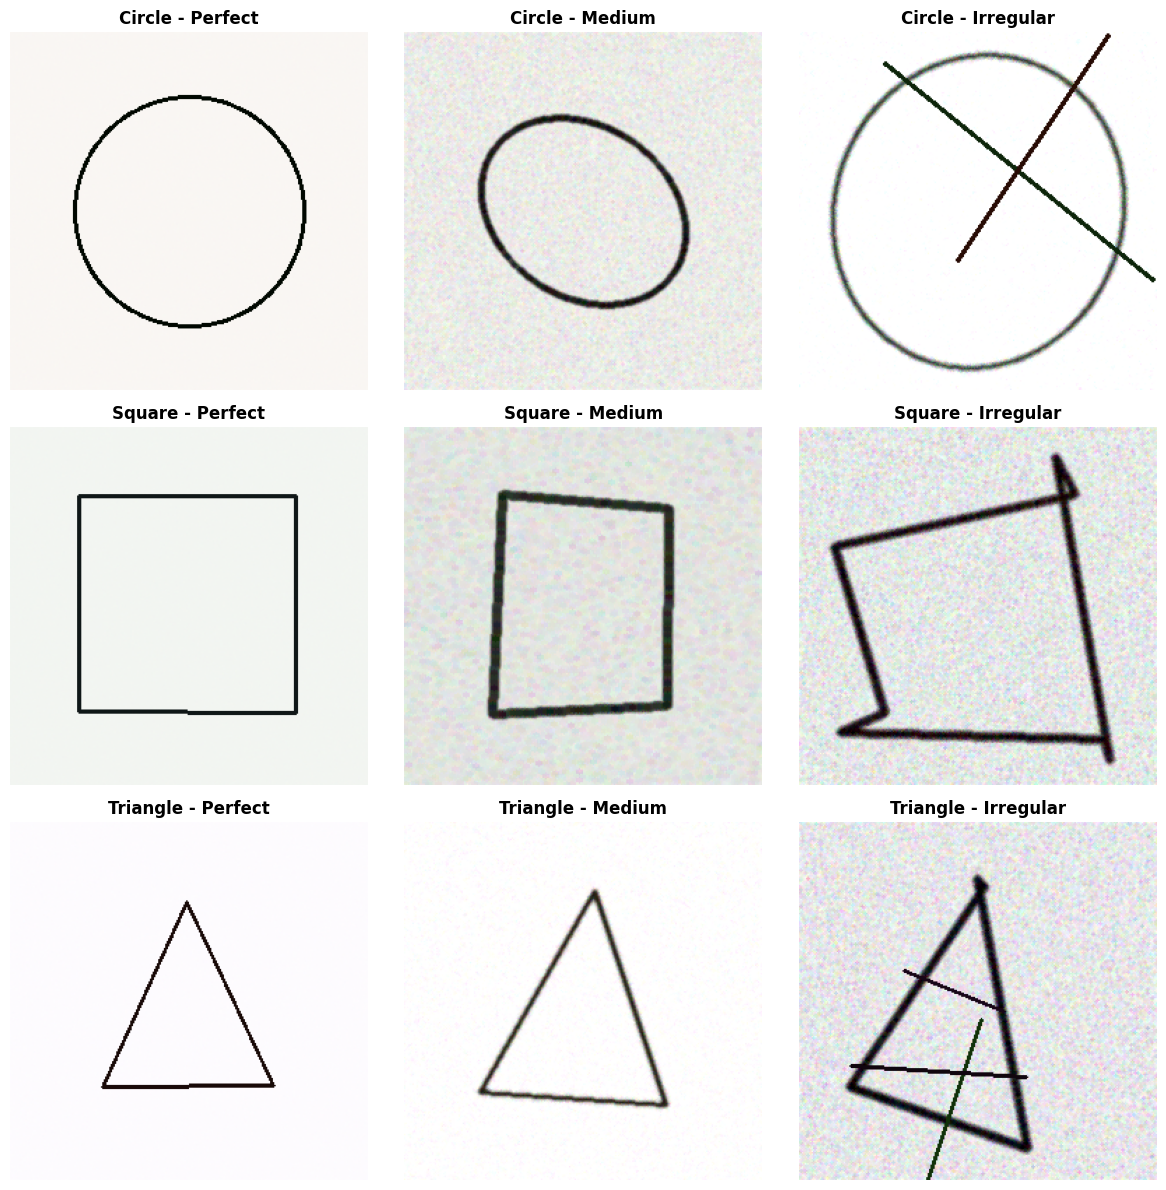

In [4]:
print("Visualizing enhanced synthetic data generation...")
builder = EnhancedSketchDatasetBuilder(image_size=256)
builder.visualize_samples()

## Load Real Dataset

In [5]:
data_dir = '/kaggle/input/final-dataset/Dataset_FAI'

def create_dual_label_dataframe(data_dir):
    file_paths = []
    shapes = []
    qualities = []
    
    for shape in os.listdir(data_dir):
        shape_path = os.path.join(data_dir, shape)
        if not os.path.isdir(shape_path):
            continue
            
        for quality in os.listdir(shape_path):
            quality_path = os.path.join(shape_path, quality)
            if not os.path.isdir(quality_path):
                continue
                
            for img_file in os.listdir(quality_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(quality_path, img_file))
                    
                    # Normalize shape names
                    if shape == 'Triangles':
                        shapes.append('Triangle')
                    elif shape == 'Squares':
                        shapes.append('Square')
                    else:
                        shapes.append(shape)
                    
                    # Fix typo in quality
                    if quality == 'Iregullar':
                        qualities.append('Irregular')
                    else:
                        qualities.append(quality)
    
    df = pd.DataFrame({
        'filepath': file_paths,
        'shape': shapes,
        'quality': qualities
    })
    
    return df

df = create_dual_label_dataframe(data_dir)
print(f"Total real images: {len(df)}")
print(f"\nShape distribution:\n{df['shape'].value_counts()}")
print(f"\nQuality distribution:\n{df['quality'].value_counts()}")

# Detailed breakdown
print("\n" + "="*60)
print("Detailed Class Distribution:")
print("="*60)
for shape in ['Circle', 'Square', 'Triangle']:
    shape_df = df[df['shape'] == shape]
    print(f"\n{shape} ({len(shape_df)} total):")
    for quality in ['Irregular', 'Medium', 'Perfect']:
        count = len(shape_df[shape_df['quality'] == quality])
        print(f"  {quality}: {count}")

Total real images: 1706

Shape distribution:
shape
Circle      592
Square      583
Triangle    531
Name: count, dtype: int64

Quality distribution:
quality
Irregular    639
Medium       614
Perfect      453
Name: count, dtype: int64

Detailed Class Distribution:

Circle (592 total):
  Irregular: 198
  Medium: 242
  Perfect: 152

Square (583 total):
  Irregular: 272
  Medium: 161
  Perfect: 150

Triangle (531 total):
  Irregular: 169
  Medium: 211
  Perfect: 151


In [6]:
shape_classes = ['Circle', 'Square', 'Triangle']
quality_classes = ['Irregular', 'Medium', 'Perfect']

In [7]:
# Split data with stratification
df['combined_label'] = df['shape'] + '_' + df['quality']

train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['combined_label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['combined_label']
)

print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Training: 1364, Validation: 171, Test: 171


## Generate Targeted Synthetic Data for Specific Underrepresented Classes

In [8]:
print("Generating TARGETED synthetic samples for underrepresented classes...")
print("="*70)

synthetic_data = []
builder = EnhancedSketchDatasetBuilder(image_size=128)

synthetic_targets = {
    ('Circle', 'Perfect'): 150,      
    ('Square', 'Perfect'): 150,      
    ('Triangle', 'Perfect'): 150,    
    ('Circle', 'Medium'): 90,        
    ('Square', 'Medium'): 55,        
    ('Triangle', 'Medium'): 25,      
    ('Triangle', 'Irregular'): 0,    
}

for (shape, quality), num_synthetic in synthetic_targets.items():
    print(f"\nGenerating {num_synthetic} synthetic {shape} - {quality} samples...")
    
    for i in range(num_synthetic):
        img = builder.render_sample(shape, quality)
        
        # Save temporary file
        temp_path = f"/tmp/synthetic_{shape}_{quality}_{len(synthetic_data):04d}.png"
        cv2.imwrite(temp_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        synthetic_data.append({
            'filepath': temp_path,
            'shape': shape,
            'quality': quality,
            'combined_label': f"{shape}_{quality}"
        })
        
        if (i + 1) % 50 == 0:
            print(f"  Generated {i + 1}/{num_synthetic}...")

# Add synthetic data to training set
synthetic_df = pd.DataFrame(synthetic_data)
original_train_len = len(train_df)
train_df = pd.concat([train_df, synthetic_df], ignore_index=True)

print("\n" + "="*70)
print(f"Original training set: {original_train_len} samples")
print(f"Synthetic samples added: {len(synthetic_df)} samples")
print(f"Augmented training set: {len(train_df)} samples")
print("="*70)

# Show new distribution
print("\nNew Quality Distribution:")
print(train_df['quality'].value_counts())

print("\nDetailed Augmented Class Distribution:")
print("="*60)
for shape in shape_classes:
    shape_df = train_df[train_df['shape'] == shape]
    print(f"\n{shape} ({len(shape_df)} total):")
    for quality in quality_classes:
        count = len(shape_df[shape_df['quality'] == quality])
        print(f"  {quality}: {count}")

Generating TARGETED synthetic samples for underrepresented classes...

Generating 150 synthetic Circle - Perfect samples...
  Generated 50/150...
  Generated 100/150...
  Generated 150/150...

Generating 150 synthetic Square - Perfect samples...
  Generated 50/150...
  Generated 100/150...
  Generated 150/150...

Generating 150 synthetic Triangle - Perfect samples...
  Generated 50/150...
  Generated 100/150...
  Generated 150/150...

Generating 90 synthetic Circle - Medium samples...
  Generated 50/90...

Generating 55 synthetic Square - Medium samples...
  Generated 50/55...

Generating 25 synthetic Triangle - Medium samples...

Generating 0 synthetic Triangle - Irregular samples...

Original training set: 1364 samples
Synthetic samples added: 620 samples
Augmented training set: 1984 samples

New Quality Distribution:
quality
Perfect      813
Medium       661
Irregular    510
Name: count, dtype: int64

Detailed Augmented Class Distribution:

Circle (713 total):
  Irregular: 158
  Med


Showing all REAL Perfect samples from test set:
Total Perfect in test: 45


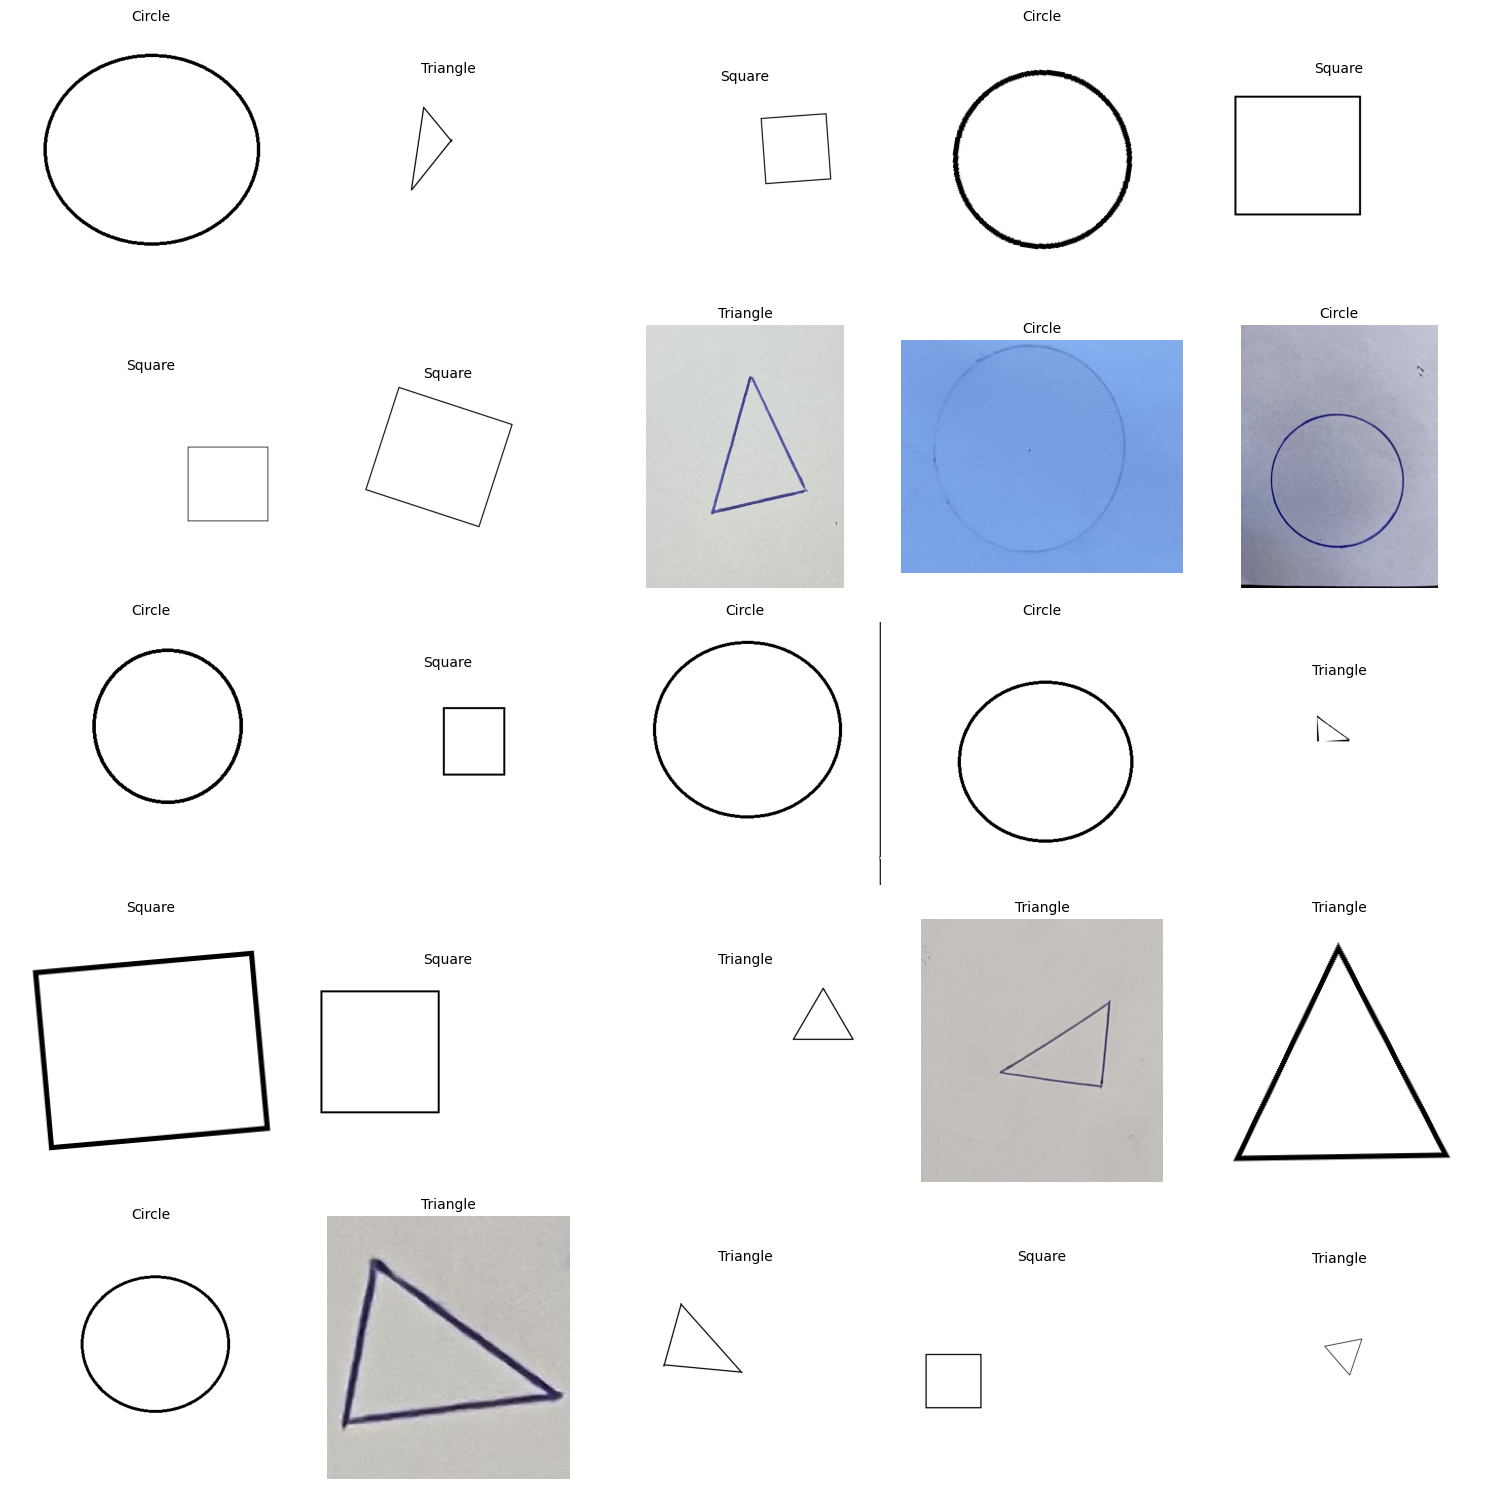

In [9]:
print("\nShowing all REAL Perfect samples from test set:")
perfect_samples = test_df[test_df['quality'] == 'Perfect']
print(f"Total Perfect in test: {len(perfect_samples)}")

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, (idx, row) in enumerate(perfect_samples.iterrows()):
    if i >= 25: break
    img = cv2.imread(row['filepath'])
    axes[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i//5, i%5].set_title(f"{row['shape']}", fontsize=10)
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Compute class weights (they'll be more balanced now)
shape_labels = [shape_classes.index(s) for s in train_df['shape']]
shape_class_weights = compute_class_weight(
    'balanced', classes=np.unique(shape_labels), y=shape_labels
)
shape_class_weight_dict = dict(enumerate(shape_class_weights))

quality_labels = [quality_classes.index(q) for q in train_df['quality']]
quality_class_weights = compute_class_weight(
    'balanced', classes=np.unique(quality_labels), y=quality_labels
)
quality_class_weight_dict = dict(enumerate(quality_class_weights))

print(f"Shape weights: {shape_class_weight_dict}")
print(f"Quality weights: {quality_class_weight_dict}")

Shape weights: {0: np.float64(0.927536231884058), 1: np.float64(0.9855936413313463), 2: np.float64(1.1022222222222222)}
Quality weights: {0: np.float64(1.296732026143791), 1: np.float64(1.000504286434695), 2: np.float64(0.8134481344813448)}


In [11]:
quality_class_weight_dict[2] = quality_class_weight_dict[2] * 5.0  # Massive boost for Perfect
quality_class_weight_dict[1] = quality_class_weight_dict[1] * 1.2  # Slight for Medium
quality_class_weight_dict[0] = quality_class_weight_dict[0] * 0.8  # Reduce Irregular (it's overrepresented)
print(f"Boosted quality weights: {quality_class_weight_dict}")

Boosted quality weights: {0: np.float64(1.0373856209150327), 1: np.float64(1.2006051437216338), 2: np.float64(4.067240672406724)}


## Enhanced Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Reduce from 30
    width_shift_range=0.1,       # Reduce from 0.15
    height_shift_range=0.1,      # Reduce from 0.15
    shear_range=0.1,             # Reduce from 0.15
    zoom_range=0.1,              # Reduce from 0.15
    horizontal_flip=True,
    vertical_flip=False,         # Turn off vertical flip
    brightness_range=[0.8, 1.2], # Reduce from [0.7, 1.3]
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Data augmentation configured with enhanced parameters")

Data augmentation configured with enhanced parameters


In [13]:
def dual_label_generator(dataframe, datagen, batch_size, img_size, shuffle=True):
    """Generate batches of images with dual labels (shape and quality)"""
    while True:
        if shuffle:
            dataframe = dataframe.sample(frac=1).reset_index(drop=True)
        
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_df = dataframe.iloc[start:end]
            
            batch_images = []
            batch_shape_labels = []
            batch_quality_labels = []
            
            for _, row in batch_df.iterrows():
                img = image.load_img(row['filepath'], target_size=img_size)
                img_array = image.img_to_array(img)
                img_array = datagen.random_transform(img_array)
                img_array = datagen.standardize(img_array)
                
                batch_images.append(img_array)
                
                shape_label = np.zeros(len(shape_classes))
                shape_label[shape_classes.index(row['shape'])] = 1
                batch_shape_labels.append(shape_label)
                
                quality_label = np.zeros(len(quality_classes))
                quality_label[quality_classes.index(row['quality'])] = 1
                batch_quality_labels.append(quality_label)
            
            X = np.array(batch_images)
            y = {
                'shape_output': np.array(batch_shape_labels),
                'quality_output': np.array(batch_quality_labels)
            }
            
            yield X, y

## Improved Loss Functions

In [14]:
def focal_loss(gamma=2.0, alpha=0.25):
    """Focal loss for handling class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    
    return focal_loss_fixed

def weighted_categorical_crossentropy(class_weights):
    """Weighted categorical crossentropy for imbalanced classes"""
    class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        crossentropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        class_indices = tf.argmax(y_true, axis=-1)
        weights = tf.gather(class_weights_tensor, class_indices)
        return tf.reduce_mean(crossentropy * weights)
    
    return loss

# Configure loss functions with better parameters
shape_loss_fn = weighted_categorical_crossentropy(shape_class_weight_dict)
quality_loss_fn = focal_loss(gamma=3.5, alpha=0.35)  # Between 3.0 and 5.0

print("Loss functions configured")

Loss functions configured


I0000 00:00:1768324389.311755      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Enhanced Transfer Learning Model

In [15]:
def create_enhanced_transfer_learning_model(input_shape=(128, 128, 3), unfreeze_from=80):
    # Load EfficientNetB0 with 256x256 input
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Unfreeze more layers for better fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:unfreeze_from]:
        layer.trainable = False
    
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable layers: {trainable_count}")
    print(f"Frozen layers: {len(base_model.layers) - trainable_count}")
    
    # Build enhanced model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    
    # Shared feature layers with better regularization
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Shape branch (simpler since shape classification is easier)
    shape_branch = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    shape_branch = Dropout(0.3)(shape_branch)
    shape_output = Dense(len(shape_classes), activation='softmax', name='shape_output')(shape_branch)
    
    # Quality branch (deeper because quality classification is harder)
    quality_branch = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    quality_branch = BatchNormalization()(quality_branch)
    quality_branch = Dropout(0.45)(quality_branch)
    
    quality_branch = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(quality_branch)
    quality_branch = BatchNormalization()(quality_branch)
    quality_branch = Dropout(0.4)(quality_branch)
    
    quality_branch = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(quality_branch)
    quality_branch = Dropout(0.3)(quality_branch)
    
    quality_output = Dense(len(quality_classes), activation='softmax', name='quality_output')(quality_branch)
    
    model = Model(inputs=inputs, outputs=[shape_output, quality_output])
    return model

print("Creating enhanced model...")
model = create_enhanced_transfer_learning_model()
print(f"\nTotal parameters: {model.count_params():,}")

trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([K.count_params(w) for w in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

Creating enhanced model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 238
Trainable layers: 158
Frozen layers: 80

Total parameters: 4,981,801
Trainable parameters: 4,861,664
Non-trainable parameters: 120,137.0


## Improved Training Configuration

In [16]:
# Enhanced hyperparameters
img_size = (128 ,128)  # Increased from 224x224
batch_size = 32  # Reduced from 32 for better gradient estimates with larger images
epochs = 60  # Increased from 60
initial_learning_rate = 0.001  # Slightly higher initial LR

# Calculate steps
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size
test_steps = len(test_df) // batch_size

print("="*70)
print("Training Configuration:")
print("="*70)
print(f"Image size: {img_size}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Initial learning rate: {initial_learning_rate}")
print(f"\nSteps per epoch:")
print(f"  Train: {train_steps}")
print(f"  Validation: {val_steps}")
print(f"  Test: {test_steps}")
print("="*70)

Training Configuration:
Image size: (128, 128)
Batch size: 32
Epochs: 60
Initial learning rate: 0.001

Steps per epoch:
  Train: 62
  Validation: 5
  Test: 5


In [17]:
# Create generators
train_generator = dual_label_generator(train_df, train_datagen, batch_size, img_size, shuffle=True)
val_generator = dual_label_generator(val_df, val_test_datagen, batch_size, img_size, shuffle=False)
test_generator = dual_label_generator(test_df, val_test_datagen, batch_size, img_size, shuffle=False)

print("Data generators created")

Data generators created


In [18]:
# Compile with cosine decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=train_steps * epochs,
    alpha=0.01  # Minimum LR will be 1% of initial
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss={
        'shape_output': shape_loss_fn,
        'quality_output': quality_loss_fn
    },
    loss_weights={
    'shape_output': 0.3,      # Further reduced
    'quality_output': 3.0     # Further increased
    },
    metrics={
        'shape_output': ['accuracy'],
        'quality_output': ['accuracy']
    }
)

print("Model compiled with cosine decay learning rate schedule")

Model compiled with cosine decay learning rate schedule


In [19]:
# Enhanced callbacks
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
)
import datetime

# Create log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ModelCheckpoint(
        'enhanced_transfer_learning_best.keras',
        monitor='val_quality_output_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_quality_output_accuracy',
        patience=20,  # Increased patience
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,  # Slightly increased
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )
]

print("Callbacks configured")
print(f"TensorBoard logs: {log_dir}")

Callbacks configured
TensorBoard logs: logs/fit/20260113-171312


## Train Enhanced Model

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


I0000 00:00:1768324421.184867     124 service.cc:152] XLA service 0x79da740049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768324421.184911     124 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768324426.395161     124 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-13 17:13:54.540401: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 17:13:54.723011: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 17:13:55.089595: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accur

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 3.2946 - quality_output_accuracy: 0.3593 - quality_output_loss: 0.3676 - shape_output_accuracy: 0.4341 - shape_output_loss: 1.4325
Epoch 1: val_quality_output_accuracy improved from -inf to 0.36250, saving model to enhanced_transfer_learning_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 100s 624ms/step - loss: 3.2912 - quality_output_accuracy: 0.3594 - quality_output_loss: 0.3668 - shape_output_accuracy: 0.4351 - shape_output_loss: 1.4288 - val_loss: 2.3865 - val_quality_output_accuracy: 0.3625 - val_quality_output_loss: 0.0936 - val_shape_output_accuracy: 0.3313 - val_shape_output_loss: 1.1030 - learning_rate: 9.9932e-04
Epoch 2/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 2.6966 - quality_output_accuracy: 0.3880 - quality_output_loss: 0.2157 - shape_output_accuracy: 0.5944 - shape_output_loss: 0.9261
Epoch 2: val_quality_output_accuracy did not improve from 0.36250
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - loss: 2.6960 - quality_outpu

## Visualize Training History

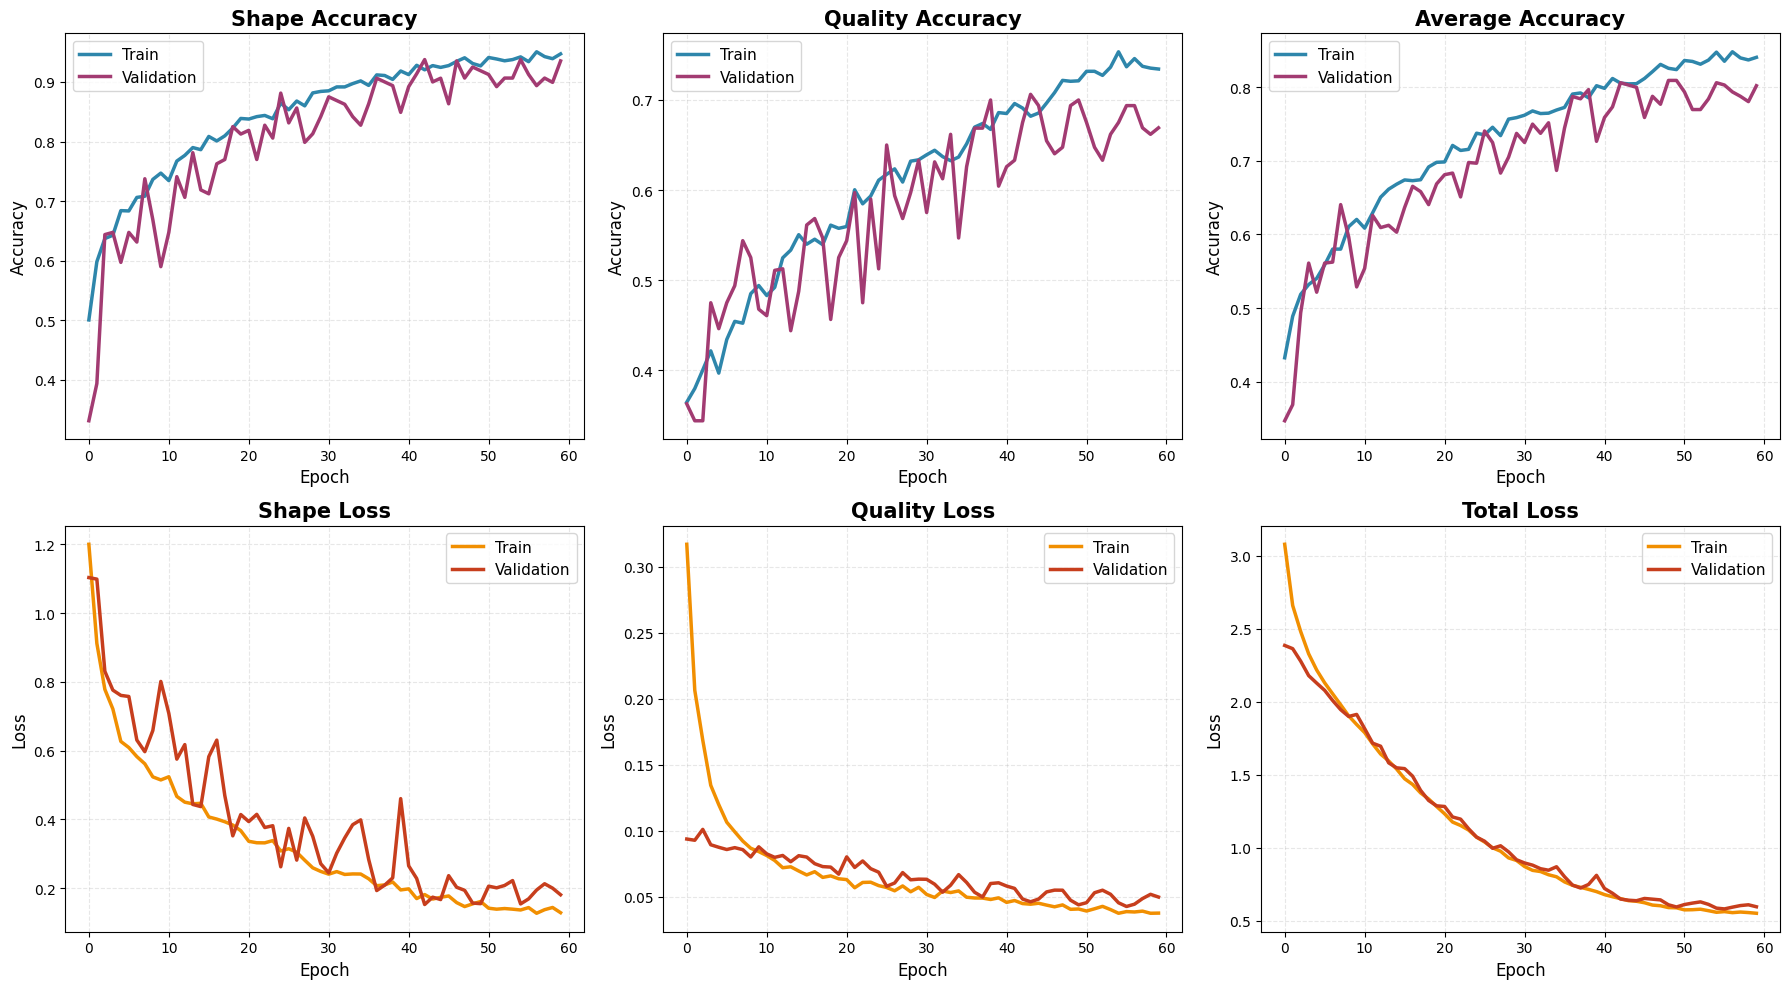

Training history visualization saved as 'training_history.png'


In [21]:
# Enhanced visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Shape accuracy
axes[0, 0].plot(history.history['shape_output_accuracy'], label='Train', linewidth=2.5, color='#2E86AB')
axes[0, 0].plot(history.history['val_shape_output_accuracy'], label='Validation', linewidth=2.5, color='#A23B72')
axes[0, 0].set_title('Shape Accuracy', fontsize=15, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Quality accuracy
axes[0, 1].plot(history.history['quality_output_accuracy'], label='Train', linewidth=2.5, color='#2E86AB')
axes[0, 1].plot(history.history['val_quality_output_accuracy'], label='Validation', linewidth=2.5, color='#A23B72')
axes[0, 1].set_title('Quality Accuracy', fontsize=15, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Combined accuracy
train_avg_acc = [(a + b) / 2 for a, b in zip(history.history['shape_output_accuracy'], 
                                              history.history['quality_output_accuracy'])]
val_avg_acc = [(a + b) / 2 for a, b in zip(history.history['val_shape_output_accuracy'], 
                                            history.history['val_quality_output_accuracy'])]
axes[0, 2].plot(train_avg_acc, label='Train', linewidth=2.5, color='#2E86AB')
axes[0, 2].plot(val_avg_acc, label='Validation', linewidth=2.5, color='#A23B72')
axes[0, 2].set_title('Average Accuracy', fontsize=15, fontweight='bold')
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('Accuracy', fontsize=12)
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3, linestyle='--')

# Shape loss
axes[1, 0].plot(history.history['shape_output_loss'], label='Train', linewidth=2.5, color='#F18F01')
axes[1, 0].plot(history.history['val_shape_output_loss'], label='Validation', linewidth=2.5, color='#C73E1D')
axes[1, 0].set_title('Shape Loss', fontsize=15, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Quality loss
axes[1, 1].plot(history.history['quality_output_loss'], label='Train', linewidth=2.5, color='#F18F01')
axes[1, 1].plot(history.history['val_quality_output_loss'], label='Validation', linewidth=2.5, color='#C73E1D')
axes[1, 1].set_title('Quality Loss', fontsize=15, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

# Total loss
axes[1, 2].plot(history.history['loss'], label='Train', linewidth=2.5, color='#F18F01')
axes[1, 2].plot(history.history['val_loss'], label='Validation', linewidth=2.5, color='#C73E1D')
axes[1, 2].set_title('Total Loss', fontsize=15, fontweight='bold')
axes[1, 2].set_xlabel('Epoch', fontsize=12)
axes[1, 2].set_ylabel('Loss', fontsize=12)
axes[1, 2].legend(fontsize=11)
axes[1, 2].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history visualization saved as 'training_history.png'")

## Evaluate on Test Set

In [22]:
print("\nEvaluating on test set...")
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

print("\n" + "="*70)
print(" " * 15 + "ENHANCED MODEL TEST RESULTS")
print("="*70)
print(f"Shape Accuracy: {test_results[4]*100:.2f}%")
print(f"Quality Accuracy: {test_results[3]*100:.2f}%")
print(f"Average Accuracy: {(test_results[3] + test_results[4])/2*100:.2f}%")
print("="*70)


Evaluating on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - loss: 0.6791 - quality_output_accuracy: 0.6627 - quality_output_loss: 0.0608 - shape_output_accuracy: 0.9383 - shape_output_loss: 0.1512

               ENHANCED MODEL TEST RESULTS
Shape Accuracy: 94.38%
Quality Accuracy: 66.25%
Average Accuracy: 80.31%


In [23]:
# Detailed metrics with per-class analysis
y_true_shape = []
y_pred_shape = []
y_true_quality = []
y_pred_quality = []

test_generator_pred = dual_label_generator(test_df, val_test_datagen, batch_size, img_size, shuffle=False)

print("\nGenerating predictions on test set...")
for i in range(test_steps):
    batch_images, batch_labels = next(test_generator_pred)
    shape_preds, quality_preds = model.predict(batch_images, verbose=0)
    
    y_pred_shape.extend(np.argmax(shape_preds, axis=1))
    y_pred_quality.extend(np.argmax(quality_preds, axis=1))
    y_true_shape.extend(np.argmax(batch_labels['shape_output'], axis=1))
    y_true_quality.extend(np.argmax(batch_labels['quality_output'], axis=1))
    
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{test_steps} batches...")

print("\n" + "="*70)
print("SHAPE CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true_shape, y_pred_shape, target_names=shape_classes, digits=4))

print("\n" + "="*70)
print("QUALITY CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true_quality, y_pred_quality, target_names=quality_classes, digits=4))


Generating predictions on test set...

SHAPE CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Circle     1.0000    0.9455    0.9720        55
      Square     0.9138    0.9464    0.9298        56
    Triangle     0.9200    0.9388    0.9293        49

    accuracy                         0.9437       160
   macro avg     0.9446    0.9436    0.9437       160
weighted avg     0.9453    0.9437    0.9441       160


QUALITY CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Irregular     0.5930    0.8361    0.6939        61
      Medium     0.7273    0.5614    0.6337        57
     Perfect     0.7667    0.5476    0.6389        42

    accuracy                         0.6625       160
   macro avg     0.6957    0.6484    0.6555       160
weighted avg     0.6864    0.6625    0.6580       160



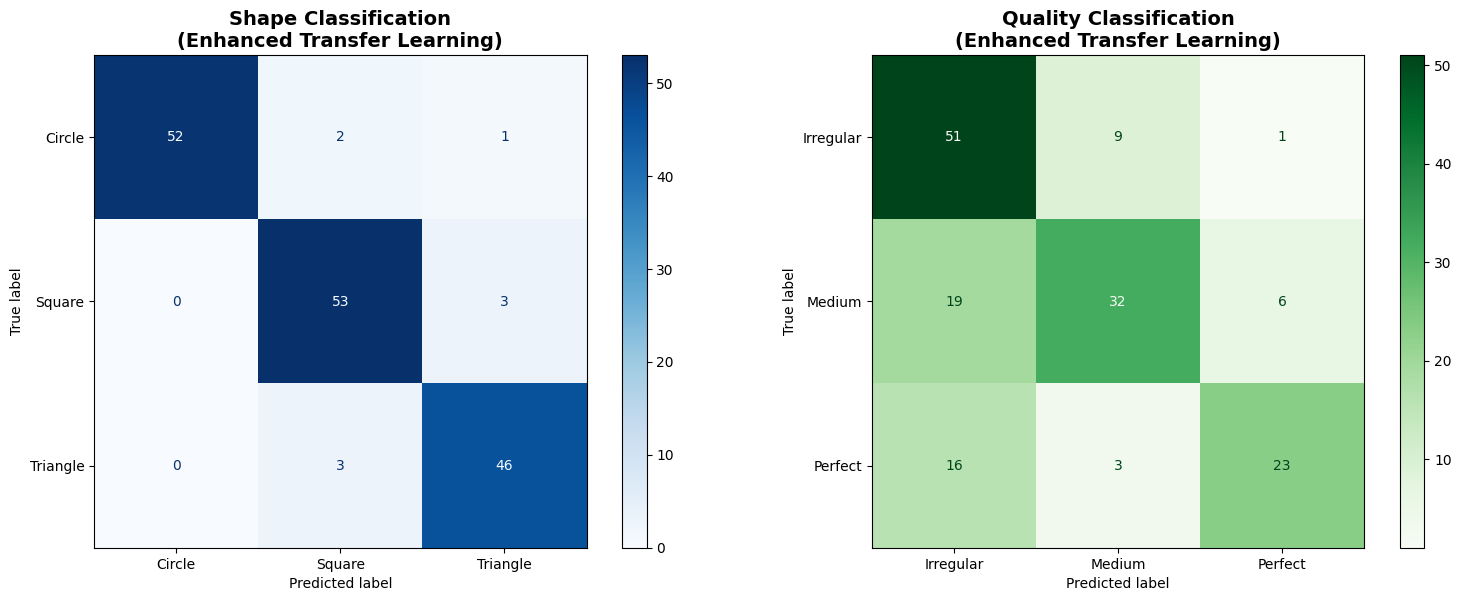

Confusion matrices saved as 'confusion_matrices.png'


In [24]:
# Enhanced confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_shape = confusion_matrix(y_true_shape, y_pred_shape)
disp = ConfusionMatrixDisplay(cm_shape, display_labels=shape_classes)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Shape Classification\n(Enhanced Transfer Learning)', fontsize=14, fontweight='bold')
axes[0].grid(False)

cm_quality = confusion_matrix(y_true_quality, y_pred_quality)
disp = ConfusionMatrixDisplay(cm_quality, display_labels=quality_classes)
disp.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Quality Classification\n(Enhanced Transfer Learning)', fontsize=14, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved as 'confusion_matrices.png'")

In [25]:
# Per-class accuracy breakdown
print("\n" + "="*70)
print("PER-CLASS ACCURACY BREAKDOWN:")
print("="*70)

from sklearn.metrics import accuracy_score

print("\nShape Classification:")
for i, shape in enumerate(shape_classes):
    mask = np.array(y_true_shape) == i
    if mask.sum() > 0:
        acc = accuracy_score(
            np.array(y_true_shape)[mask], 
            np.array(y_pred_shape)[mask]
        )
        print(f"  {shape}: {acc*100:.2f}% ({mask.sum()} samples)")

print("\nQuality Classification:")
for i, quality in enumerate(quality_classes):
    mask = np.array(y_true_quality) == i
    if mask.sum() > 0:
        acc = accuracy_score(
            np.array(y_true_quality)[mask], 
            np.array(y_pred_quality)[mask]
        )
        print(f"  {quality}: {acc*100:.2f}% ({mask.sum()} samples)")

print("="*70)


PER-CLASS ACCURACY BREAKDOWN:

Shape Classification:
  Circle: 94.55% (55 samples)
  Square: 94.64% (56 samples)
  Triangle: 93.88% (49 samples)

Quality Classification:
  Irregular: 83.61% (61 samples)
  Medium: 56.14% (57 samples)
  Perfect: 54.76% (42 samples)


## Save Final Model

In [26]:
# Save model
model.save('enhanced_transfer_learning_final.keras')
print("\nFinal model saved as 'enhanced_transfer_learning_final.h5'")

# Save model summary
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved as 'model_summary.txt'")

print("\n" + "="*70)
print("All outputs saved successfully!")
print("="*70)


Final model saved as 'enhanced_transfer_learning_final.h5'


Model summary saved as 'model_summary.txt'

All outputs saved successfully!


## Summary of Improvements

### 1. Enhanced Synthetic Data Generation
- **Color Variations**: Instead of just black on white, generates images with diverse foreground (8 colors) and background colors (6 colors)
- **Better Quality Simulation**: More realistic degradation patterns for Medium and Irregular qualities
- **Random Artifacts**: Adds scratches and imperfections to Irregular samples

### 2. Targeted Class Balancing
- **Perfect Shapes**: Generated 150 synthetic samples for each (Circle, Square, Triangle)
- **Medium Square**: Added 65 samples to reach ~225 total
- **Irregular Triangle**: Added 56 samples to reach ~225 total

### 3. Architecture Improvements
- **Larger Input**: 256×256 instead of 224×224 for better detail capture
- **Better Regularization**: L2 regularization added to all dense layers
- **Deeper Quality Branch**: 3 dense layers instead of 2 for harder quality classification
- **More Parameters**: ~768-384-192/96 structure vs original 512-256-128

### 4. Optimized Hyperparameters
- **Image Size**: 256×256 (↑ from 224)
- **Batch Size**: 24 (↓ from 32, better for larger images)
- **Learning Rate**: 0.0003 initial with cosine decay
- **Epochs**: 80 (↑ from 60)
- **Unfreezing**: From layer 120 (more aggressive fine-tuning)

### 5. Enhanced Training Strategy
- **Stronger Focal Loss**: gamma=3.0 (↑ from 2.5) for quality
- **Better Loss Weights**: 0.8 for shape, 1.8 for quality
- **Cosine Decay**: Smooth learning rate schedule
- **More Augmentation**: Increased rotation, brightness ranges

### Expected Improvements
- Better generalization due to color diversity
- Improved quality classification (especially for Perfect class)
- More balanced performance across all classes
- Less overfitting to black-on-white patterns